In [69]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns

import acbm
from acbm.validating.plots import plot_comparison, plot_activity_sequence_comparison, plot_intrazonal_trips
from acbm.validating.utils import calculate_od_distances, process_sequences


## 1. Overview figure of AcBM

TODO: add some description
![acbm](https://urban-analytics-technology-platform.github.io/blog_content/v2_release/acbm_diagram.png)


## 2. Read generated activity chains


The four outputs from the AcBM pipline are the following files:
- `people.csv` (SPC)
- `households.csv` (SPC)
- TODO: add SPC builder to load people and households
- `activities.csv` (AcBM)
- `legs.csv` (AcBM (primary), PAM (secondary))
- `legs_with_locations.parquet` (AcBM (primary), PAM (secondary))
- `plans.xml` (AcBM, PAM): MATSim output include background demographics as extra features

In [70]:
processed_dir = "data/processed/activities_pam/"

# People
people = pd.read_csv(acbm.root_path / processed_dir / "people.csv")


In [71]:
people.head()

,pid,hid,freq,hzone,age_years
0,199,89,NaN,E00059031,39
1,200,89,NaN,E00059031,38
2,201,89,NaN,E00059031,7
3,312,139,NaN,E00059045,64
4,425,197,NaN,E00059023,59


In [72]:
# Households
housholds = pd.read_csv(acbm.root_path / processed_dir / "households.csv")
housholds.head()

,hid,freq,hzone
0,89,NaN,E00059031
1,139,NaN,E00059045
2,197,NaN,E00059023
3,371,NaN,E00059016
4,610,NaN,E00059016


In [73]:
# Activities: (rows are trips wit times, duration and zone (of the activity) and ordinal value for trip within the day)
activities = pd.read_csv(acbm.root_path / processed_dir / "activities.csv")[[
    "pid", "hid", "activity", "seq", "start time", "end time", "duration", "zone"
]]
activities

,pid,hid,activity,seq,start time,end time,duration,zone
0,199,89,home,0.0,1900-01-01 00:00:00,1900-01-01 03:40:00,3:40:00,E00059031
1,199,89,work,2.0,1900-01-01 03:55:00,1900-01-01 15:00:00,11:05:00,E00059010
2,199,89,home,3.0,1900-01-01 15:25:00,1900-01-01 16:15:00,0:50:00,E00059031
3,199,89,escort,4.0,1900-01-01 16:20:00,1900-01-01 16:30:00,0:10:00,E00187029
4,199,89,home,5.0,1900-01-01 16:35:00,1900-01-01 17:25:00,0:50:00,E00059031
...,...,...,...,...,...,...,...,...
21168,794273,334647,home,3.0,1900-01-01 11:30:00,1900-01-01 12:30:00,1:00:00,E00170040
21169,794273,334647,shop,4.0,1900-01-01 12:45:00,1900-01-01 17:10:00,4:25:00,E00170433
21170,794273,334647,home,5.0,1900-01-01 17:30:00,1900-01-01 19:00:00,1:30:00,E00170040
21171,794273,334647,other,6.0,1900-01-01 19:05:00,1900-01-01 20:20:00,1:15:00,E00057576


## Activities

__Rows are activities in a specific location with times, duration and zone (of the activity) and ordinal value for trip within the day__

In [74]:

activities_ = pd.read_csv(acbm.root_path / processed_dir / "activities.csv")[[
    "pid", "hid", "activity", "seq", "start time", "end time", "duration", "zone"
]]
activities

,pid,hid,activity,seq,start time,end time,duration,zone
0,199,89,home,0.0,1900-01-01 00:00:00,1900-01-01 03:40:00,3:40:00,E00059031
1,199,89,work,2.0,1900-01-01 03:55:00,1900-01-01 15:00:00,11:05:00,E00059010
2,199,89,home,3.0,1900-01-01 15:25:00,1900-01-01 16:15:00,0:50:00,E00059031
3,199,89,escort,4.0,1900-01-01 16:20:00,1900-01-01 16:30:00,0:10:00,E00187029
4,199,89,home,5.0,1900-01-01 16:35:00,1900-01-01 17:25:00,0:50:00,E00059031
...,...,...,...,...,...,...,...,...
21168,794273,334647,home,3.0,1900-01-01 11:30:00,1900-01-01 12:30:00,1:00:00,E00170040
21169,794273,334647,shop,4.0,1900-01-01 12:45:00,1900-01-01 17:10:00,4:25:00,E00170433
21170,794273,334647,home,5.0,1900-01-01 17:30:00,1900-01-01 19:00:00,1:30:00,E00170040
21171,794273,334647,other,6.0,1900-01-01 19:05:00,1900-01-01 20:20:00,1:15:00,E00057576


### Legs with locations

__Each row is a trip linking activities in a given day for a given person__

Notes (TODO: add some more descriptions for noteworthy columns):
- location IDs match with the osmox POI geoparquet file downloaded in script `0.1_osmox.py`

In [75]:
# TODO: Pick two HIDs as examples (person 6 and person 18) if need to have fast runtime

legs_with_locations = pd.read_parquet(
    acbm.root_path / "data/processed/activities_pam/legs_with_locations.parquet"
)
legs_with_locations[
    [
        "pid",
        "hid",
        "ozone",
        "dzone",
        "origin activity",
        "destination activity",
        "mode",
        "seq",
        "tst",
        "tet",
        "duration",
        "start_location_id",
        "end_location_id",
        "start_location_geometry_wkt",
        "end_location_geometry_wkt"
    ]
]

# Add geometries
legs_with_locations["start_location_geometry"] = gpd.GeoSeries.from_wkt(legs_with_locations["start_location_geometry_wkt"])
legs_with_locations["end_location_geometry"] = gpd.GeoSeries.from_wkt(legs_with_locations["end_location_geometry_wkt"])



In [76]:
from shapely import LineString

legs_with_locations["geometry"] = legs_with_locations[
    ["start_location_geometry", "end_location_geometry"]
].apply(
    lambda row: LineString(
        [row["start_location_geometry"], row["end_location_geometry"]]
    )
    if row["start_location_geometry"] is not None
    and row["end_location_geometry"] is not None
    else pd.NA,
    axis=1,
)


In [77]:
# Load boundaries
boundaries = gpd.read_file(
    acbm.root_path / "data/external/boundaries" / "oa_england.geojson",
    where="MSOA21NM LIKE '%Leeds%'",
).to_crs("epsg:4326")


In [78]:
geo_legs_with_locations = gpd.GeoDataFrame(legs_with_locations, crs="epsg:4326")

In [79]:
# get n random unique hids
n = 5
hids = np.random.choice(housholds["hid"].unique(), n, replace=False)
hids = hids.tolist()
hids


[50733, 18007, 216565, 211656, 194501]

In [80]:
# get dtype of legs_subset["tst"]
legs_with_locations["tet"].dtype


dtype('O')

In [81]:
# generate subset and distinct dataframes from start, end, trip
# hids = [89, 139]
# pids = [6, 18]
# hids = range(1, 100)
# pids = range(1, 100)
from matplotlib.colors import to_hex

legs_subset = geo_legs_with_locations[geo_legs_with_locations["hid"].isin(hids)]
start = legs_subset[["pid", "hid", "start_location_geometry", "origin activity", "seq"]]
end = legs_subset[["pid", "hid", "end_location_geometry", "destination activity"]]
trips = legs_subset[["pid", "hid", "geometry", "mode", "seq", "tst", "tet"]]

# Convert 'tst' and 'tet' columns to datetime 
trips['tst'] = pd.to_datetime(trips['tst'], errors='coerce').dt.time
trips['tet'] = pd.to_datetime(trips['tet'], errors='coerce').dt.time

modes = trips["mode"].unique()  # Collect all unique modes
colormap = plt.colormaps.get_cmap("Dark2")  # Generate a colormap
#mode_colors = {mode: colormap(i) for i, mode in enumerate(modes)}  # Map modes to colors
# Map each mode to a hex color
mode_colors = {mode: to_hex(colormap(i)) for i, mode in enumerate(modes)}

activities_unique = start["origin activity"].unique()  # Collect all unique modes
colormap = plt.colormaps.get_cmap("Accent")  # Generate a colormap
act_colors = {act: to_hex(colormap(i)) for i, act in enumerate(activities_unique)}


/home/hussein/.cache/pypoetry/virtualenvs/acbm-7iKwKWLy-py3.10/lib/python3.10/site-packages/geopandas/geodataframe.py:1528: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/hussein/.cache/pypoetry/virtualenvs/acbm-7iKwKWLy-py3.10/lib/python3.10/site-packages/geopandas/geodataframe.py:1528: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [82]:
mode_colors

{'walk': '#1b9e77', 'car': '#d95f02', 'pt': '#7570b3'}

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

for hid in start["hid"].unique():
    for pid in start[start["hid"].eq(hid)]["pid"].unique():
        print(hid, pid)
        start_p = start[start["pid"].eq(pid)]
        end_p = end[end["pid"].eq(pid)]
        trips_p = trips[trips["pid"].eq(pid)]

        fig, ax = plt.subplots(1, trips_p["seq"].unique().shape[0])
        fig.set_size_inches(15, 10)
        for i, seq in enumerate(trips_p["seq"]):
            boundaries.plot(ax=ax[i], color="lightgrey")
            
            # Map the 'origin activity' to colors and handle NaN values
            start_colors = start_p["origin activity"].map(act_colors).fillna('gray')
            start_p.set_geometry("start_location_geometry").plot(ax=ax[i], color=start_colors)
            
            # Map the 'destination activity' to colors and handle NaN values
            end_colors = end_p["destination activity"].map(act_colors).fillna('gray')
            end_p.set_geometry("end_location_geometry").plot(ax=ax[i], color=end_colors)
            
            if trips_p[trips_p["seq"].lt(seq)].shape[0] > 0:
                trips_p[trips_p["seq"].lt(seq)].plot(ax=ax[i], color=trips_p["mode"].map(mode_colors).fillna('grey'), alpha=0.1)
            trips_p[trips_p["seq"].eq(seq)].plot(ax=ax[i], color=trips_p["mode"].map(mode_colors).fillna('grey'), alpha=1.0)
            
            # Set the title and axis off
            ax[i].set_title(f"Seq: {seq}", fontsize="medium")
            ax[i].axis("off")
        
        # Create custom legend handles
        activity_handles = [Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=activity) for activity, color in act_colors.items()]
        mode_handles = [Line2D([0], [0], color=color, lw=2, label=mode) for mode, color in mode_colors.items()]


        # Adjust layout to make space for legends
        plt.tight_layout()
        fig.subplots_adjust(bottom=0.3)

        # Add legends to the main plot
        legend1 = fig.legend(handles=activity_handles, loc='lower center', ncol=len(activity_handles), title="Origin Activity", bbox_to_anchor=(0.5, -0.1), bbox_transform=fig.transFigure)
        legend2 = fig.legend(handles=mode_handles, loc='lower center', ncol=len(mode_handles), title="Mode", bbox_to_anchor=(0.5, -0.2), bbox_transform=fig.transFigure)

        # Add legends to the figure
        fig.add_artist(legend1)
        fig.add_artist(legend2)

        plt.show()
        


Updated plot with legend and title (seq, tst, tet)

18007 39508


/home/hussein/.cache/pypoetry/virtualenvs/acbm-7iKwKWLy-py3.10/lib/python3.10/site-packages/geopandas/geodataframe.py:1528: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/hussein/.cache/pypoetry/virtualenvs/acbm-7iKwKWLy-py3.10/lib/python3.10/site-packages/geopandas/geodataframe.py:1528: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/hussein/.cache/pypoetry/virtualenvs/acbm-7iKwKWLy-py3.10/lib/python3.10/site-packages/geopandas/geodat

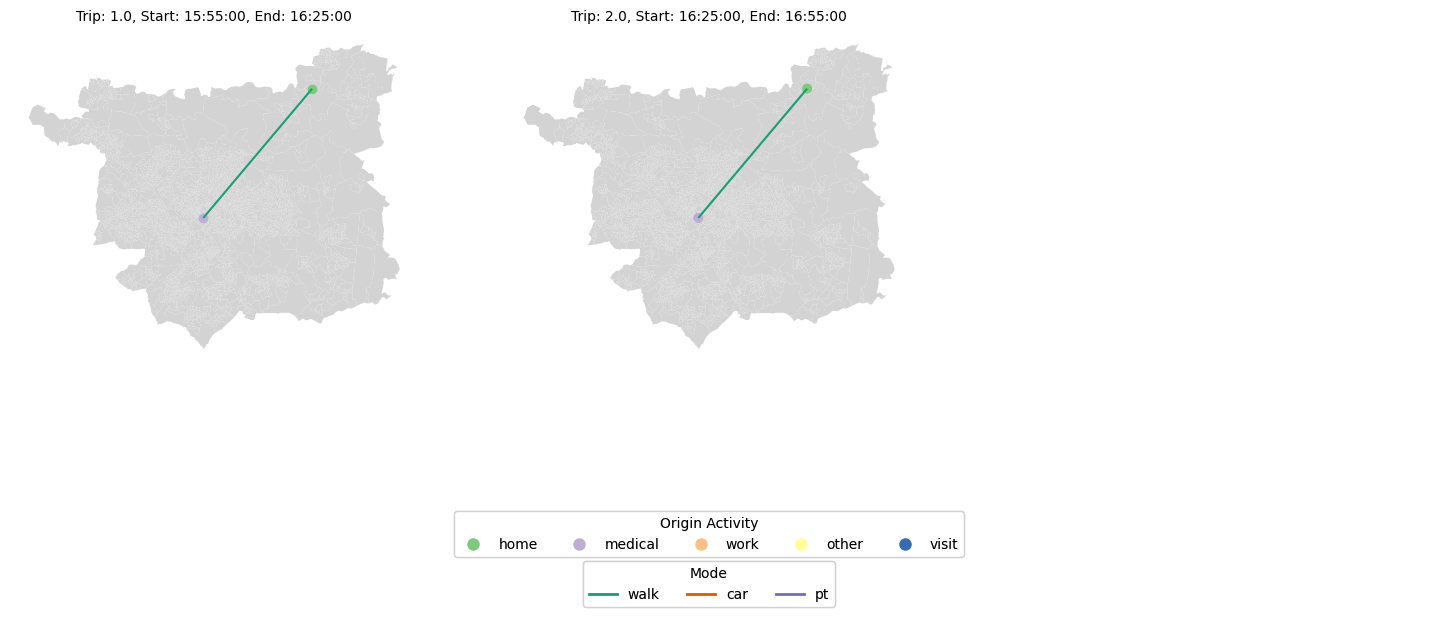

18007 39509


/home/hussein/.cache/pypoetry/virtualenvs/acbm-7iKwKWLy-py3.10/lib/python3.10/site-packages/geopandas/geodataframe.py:1528: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/hussein/.cache/pypoetry/virtualenvs/acbm-7iKwKWLy-py3.10/lib/python3.10/site-packages/geopandas/geodataframe.py:1528: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/hussein/.cache/pypoetry/virtualenvs/acbm-7iKwKWLy-py3.10/lib/python3.10/site-packages/geopandas/geodat

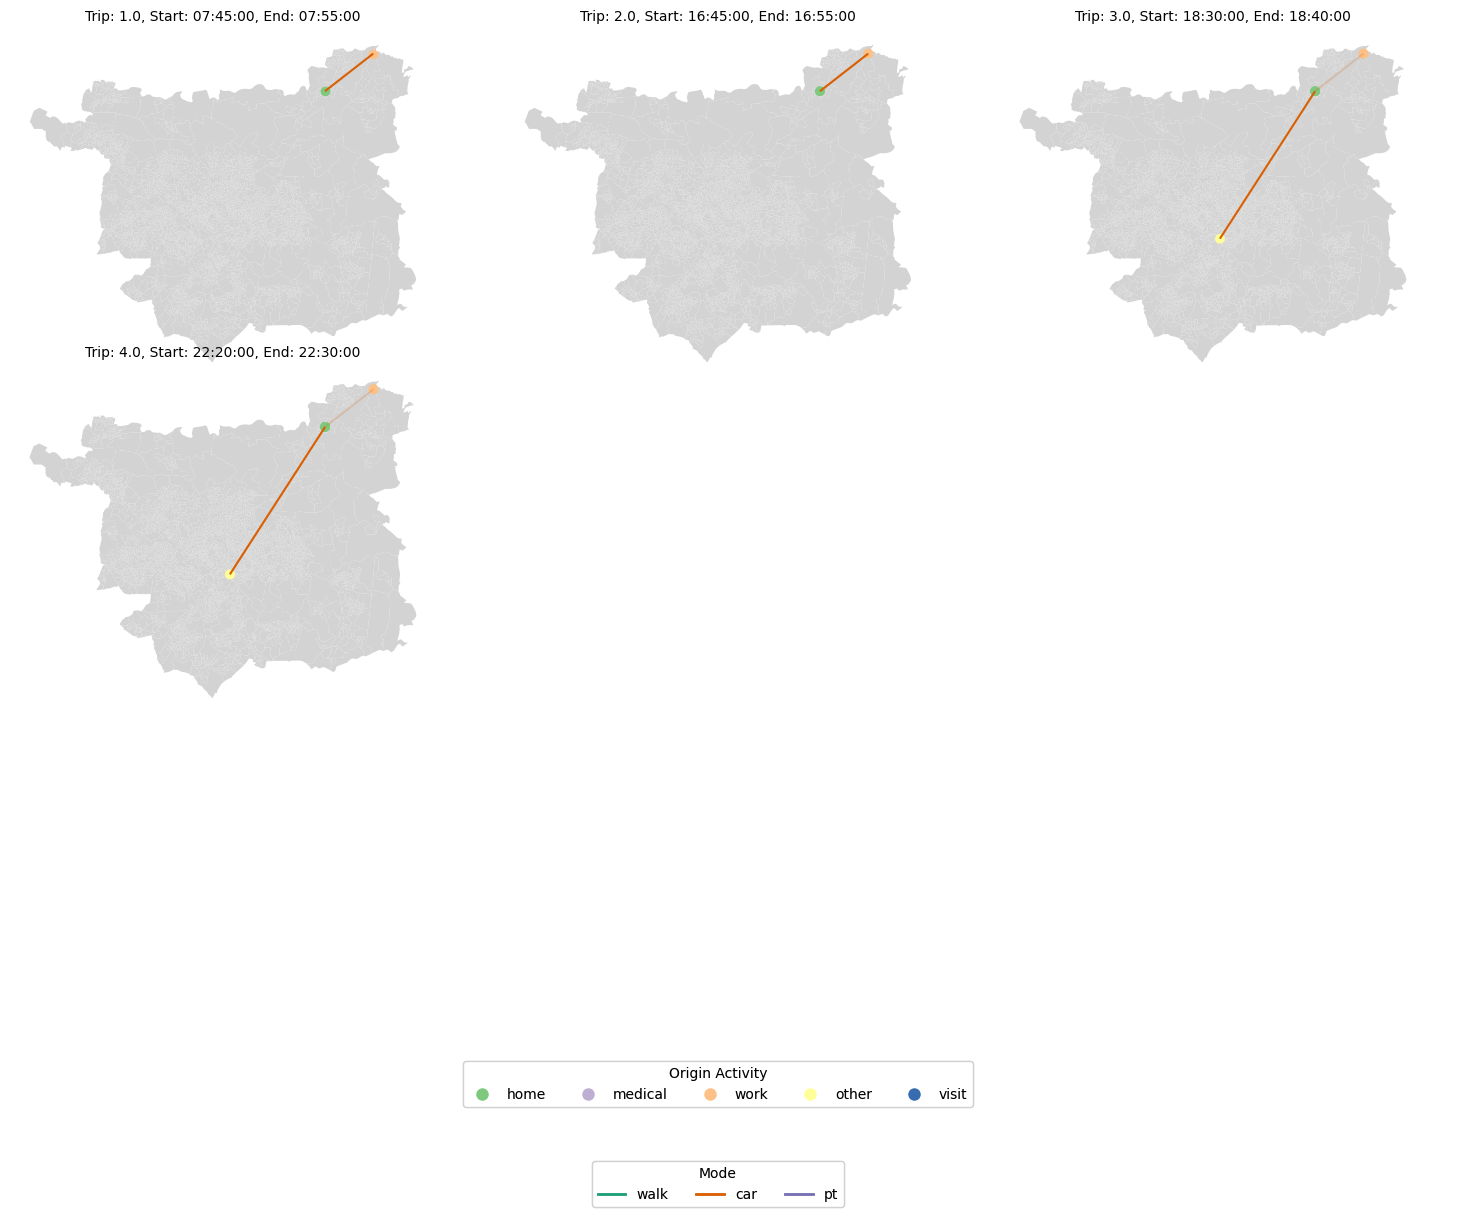

50733 112361


/home/hussein/.cache/pypoetry/virtualenvs/acbm-7iKwKWLy-py3.10/lib/python3.10/site-packages/geopandas/geodataframe.py:1528: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/hussein/.cache/pypoetry/virtualenvs/acbm-7iKwKWLy-py3.10/lib/python3.10/site-packages/geopandas/geodataframe.py:1528: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/hussein/.cache/pypoetry/virtualenvs/acbm-7iKwKWLy-py3.10/lib/python3.10/site-packages/geopandas/geodat

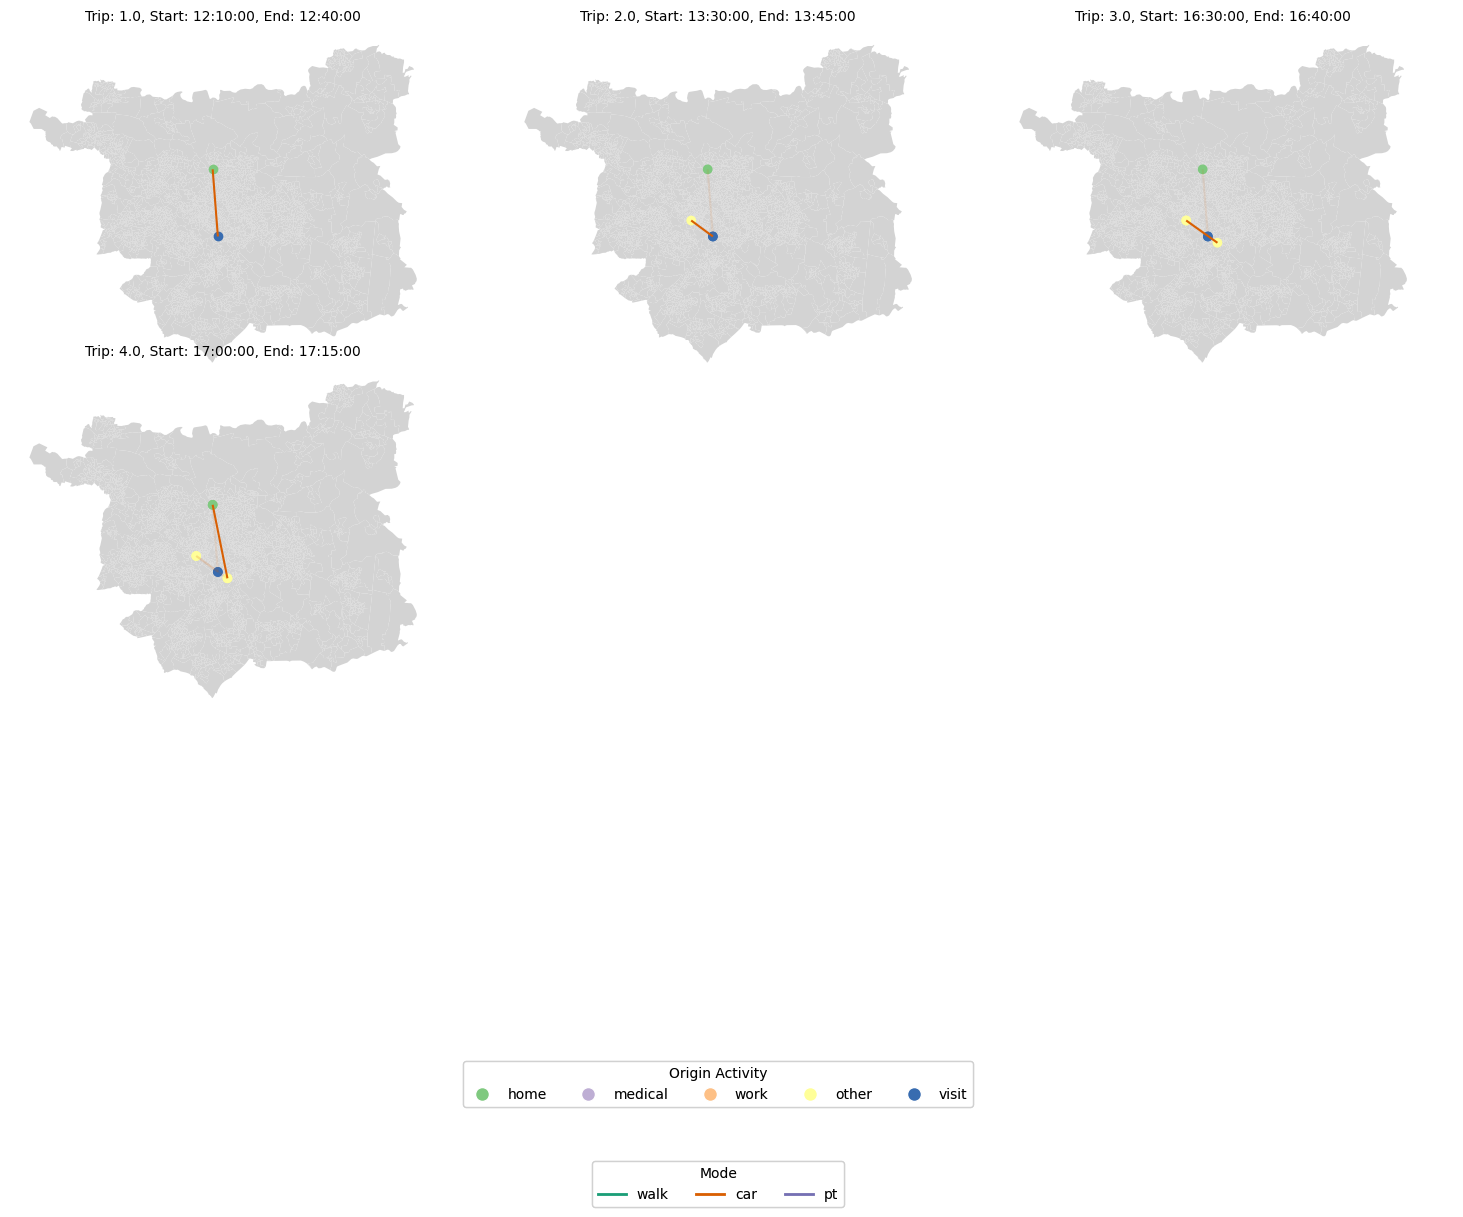

50733 112363


/home/hussein/.cache/pypoetry/virtualenvs/acbm-7iKwKWLy-py3.10/lib/python3.10/site-packages/geopandas/geodataframe.py:1528: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/hussein/.cache/pypoetry/virtualenvs/acbm-7iKwKWLy-py3.10/lib/python3.10/site-packages/geopandas/geodataframe.py:1528: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/hussein/.cache/pypoetry/virtualenvs/acbm-7iKwKWLy-py3.10/lib/python3.10/site-packages/geopandas/geodat

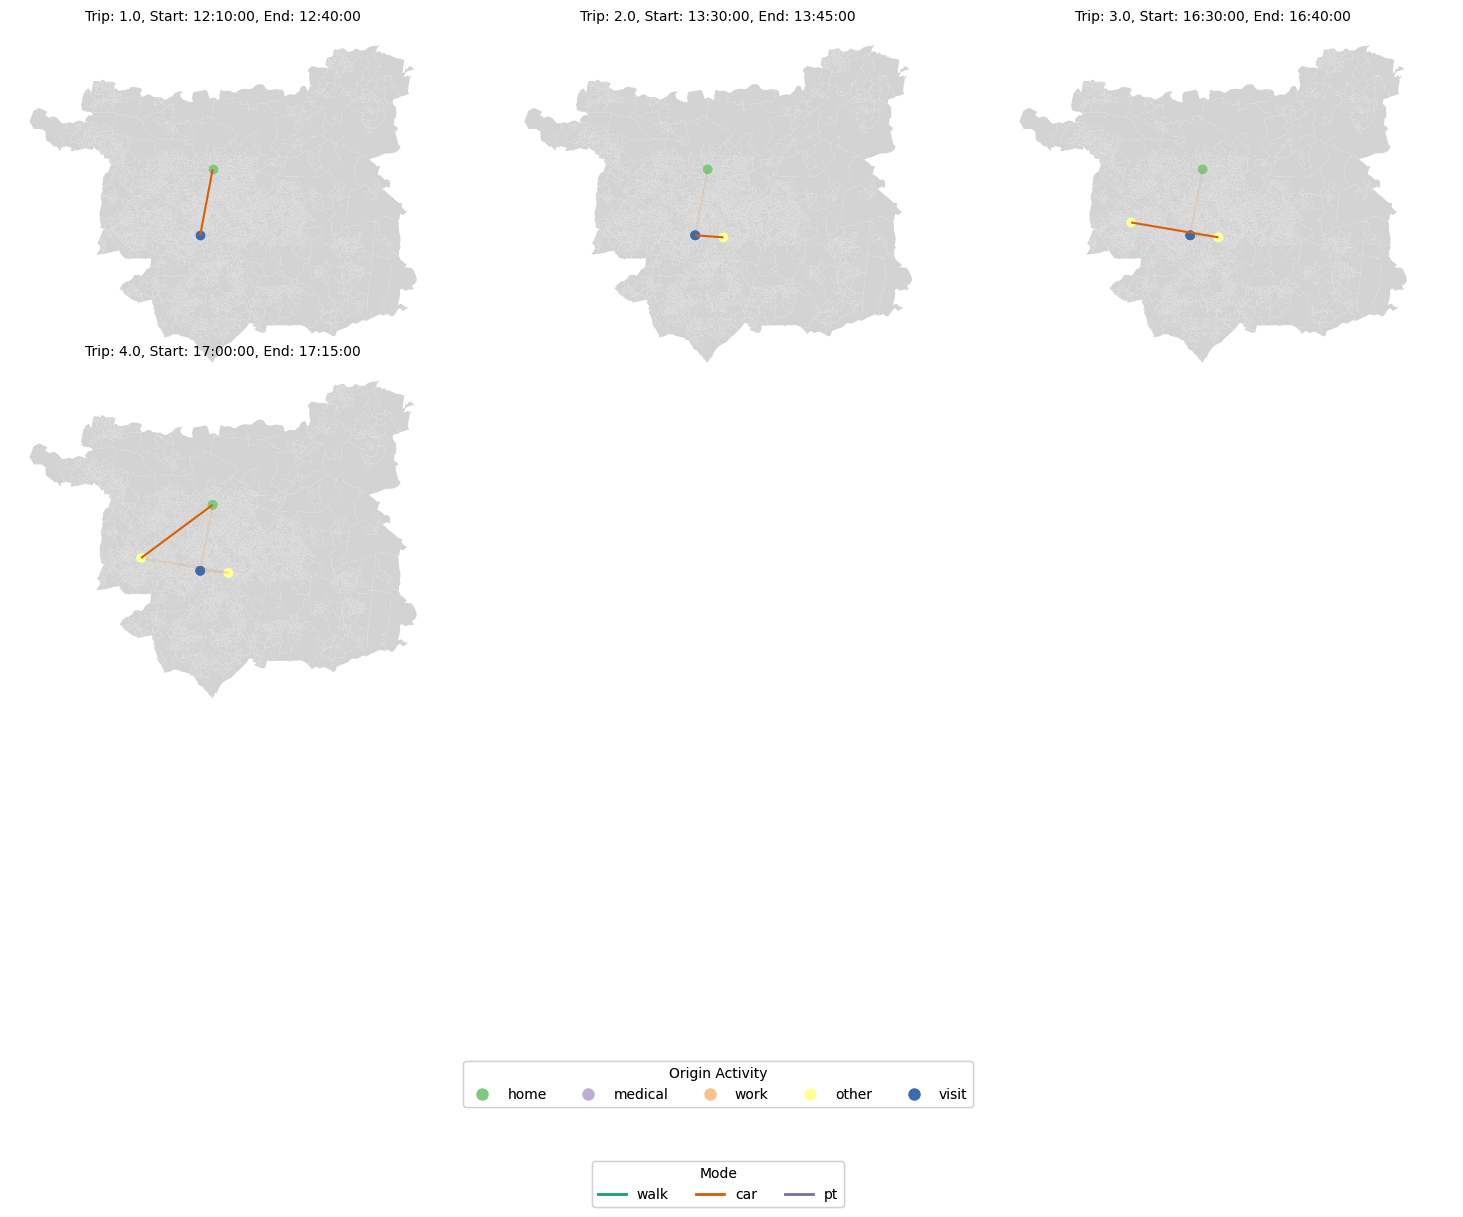

50733 112364


/home/hussein/.cache/pypoetry/virtualenvs/acbm-7iKwKWLy-py3.10/lib/python3.10/site-packages/geopandas/geodataframe.py:1528: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/hussein/.cache/pypoetry/virtualenvs/acbm-7iKwKWLy-py3.10/lib/python3.10/site-packages/geopandas/geodataframe.py:1528: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/hussein/.cache/pypoetry/virtualenvs/acbm-7iKwKWLy-py3.10/lib/python3.10/site-packages/geopandas/geodat

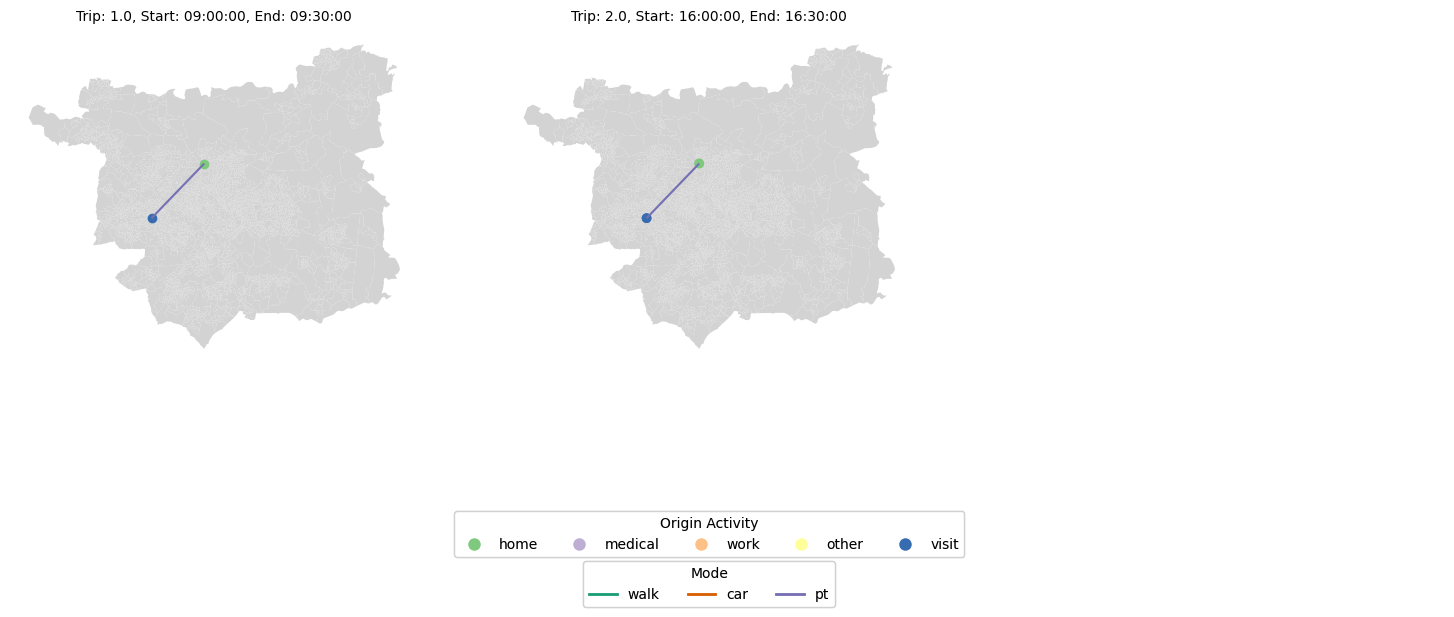

50733 112365


/home/hussein/.cache/pypoetry/virtualenvs/acbm-7iKwKWLy-py3.10/lib/python3.10/site-packages/geopandas/geodataframe.py:1528: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/hussein/.cache/pypoetry/virtualenvs/acbm-7iKwKWLy-py3.10/lib/python3.10/site-packages/geopandas/geodataframe.py:1528: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/hussein/.cache/pypoetry/virtualenvs/acbm-7iKwKWLy-py3.10/lib/python3.10/site-packages/geopandas/geodat

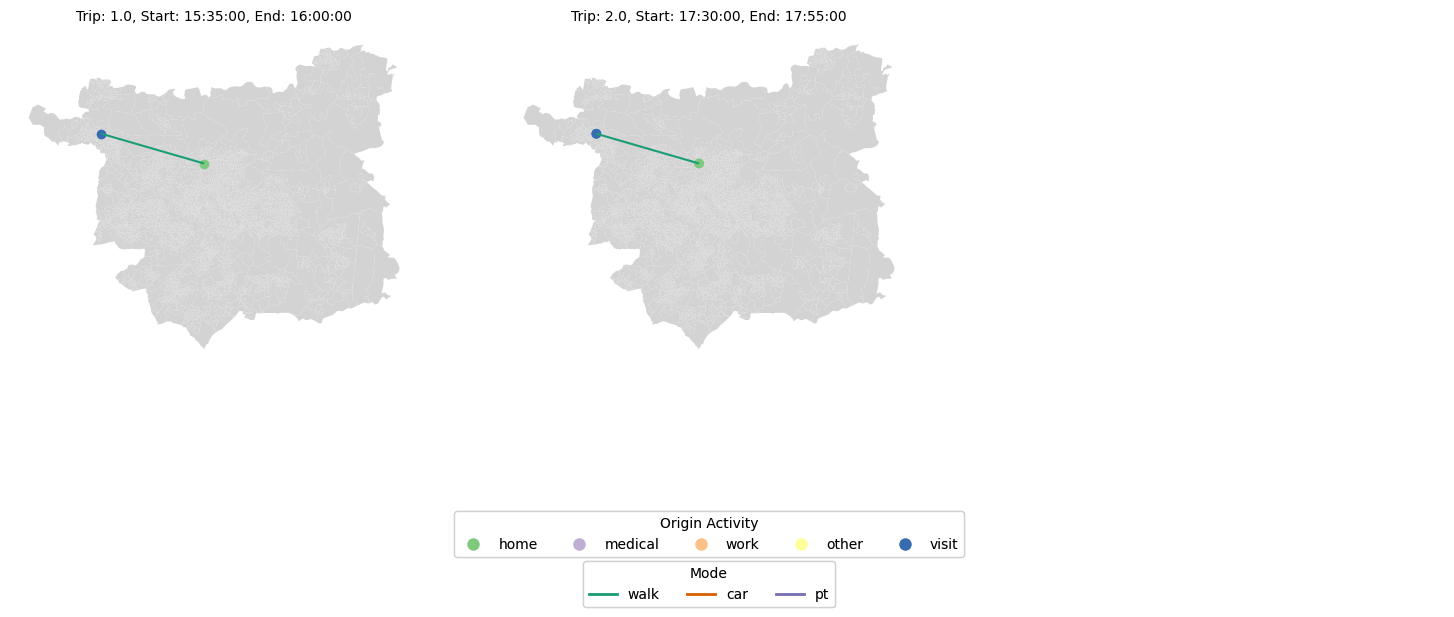

194501 461847


/home/hussein/.cache/pypoetry/virtualenvs/acbm-7iKwKWLy-py3.10/lib/python3.10/site-packages/geopandas/geodataframe.py:1528: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/hussein/.cache/pypoetry/virtualenvs/acbm-7iKwKWLy-py3.10/lib/python3.10/site-packages/geopandas/geodataframe.py:1528: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/hussein/.cache/pypoetry/virtualenvs/acbm-7iKwKWLy-py3.10/lib/python3.10/site-packages/geopandas/geodat

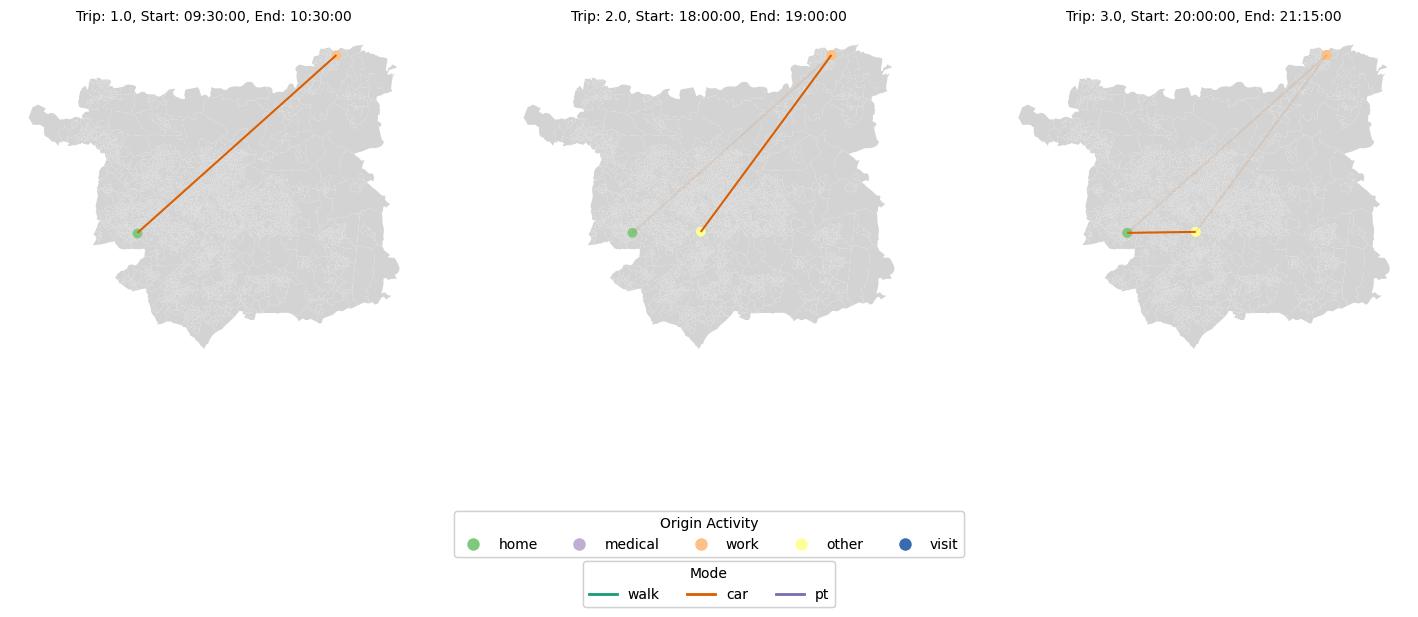

211656 500559


/home/hussein/.cache/pypoetry/virtualenvs/acbm-7iKwKWLy-py3.10/lib/python3.10/site-packages/geopandas/geodataframe.py:1528: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/hussein/.cache/pypoetry/virtualenvs/acbm-7iKwKWLy-py3.10/lib/python3.10/site-packages/geopandas/geodataframe.py:1528: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/hussein/.cache/pypoetry/virtualenvs/acbm-7iKwKWLy-py3.10/lib/python3.10/site-packages/geopandas/geodat

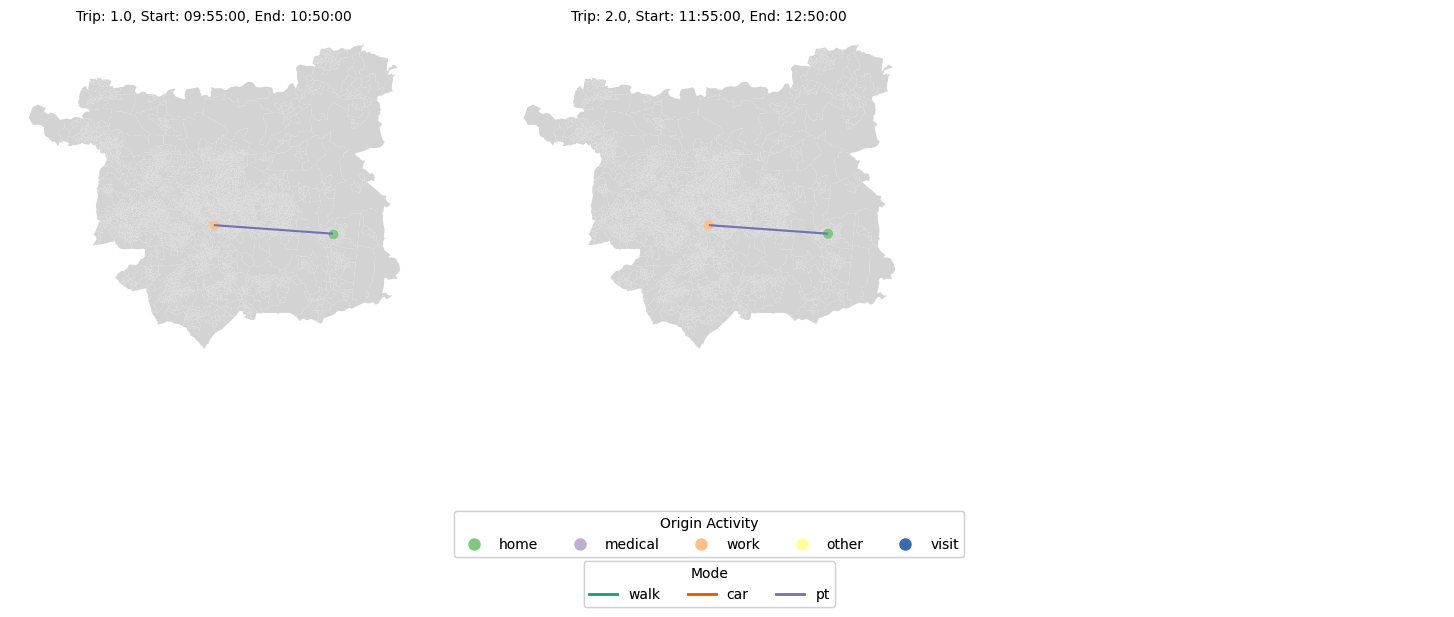

216565 511391


/home/hussein/.cache/pypoetry/virtualenvs/acbm-7iKwKWLy-py3.10/lib/python3.10/site-packages/geopandas/geodataframe.py:1528: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/hussein/.cache/pypoetry/virtualenvs/acbm-7iKwKWLy-py3.10/lib/python3.10/site-packages/geopandas/geodataframe.py:1528: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/hussein/.cache/pypoetry/virtualenvs/acbm-7iKwKWLy-py3.10/lib/python3.10/site-packages/geopandas/geodat

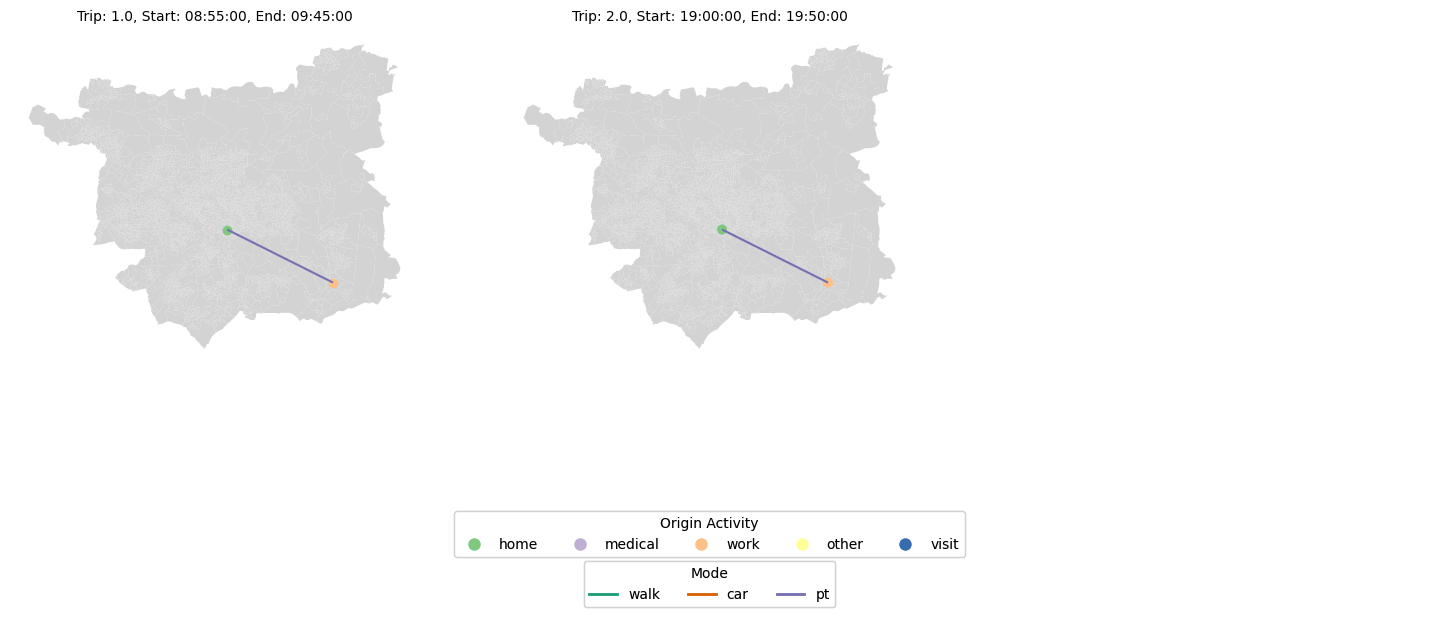

In [83]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import math

# Set a fixed number of columns
n_cols = 3

for hid in start["hid"].unique():
    for pid in start[start["hid"].eq(hid)]["pid"].unique():
        print(hid, pid)
        start_p = start[start["pid"].eq(pid)]
        end_p = end[end["pid"].eq(pid)]
        trips_p = trips[trips["pid"].eq(pid)]

        # Get unique sequence values and calculate the number of rows required
        seq_values = trips_p["seq"].unique()
        n_rows = math.ceil(len(seq_values) / n_cols)  # Calculate rows based on number of columns

        fig, axs = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows), squeeze=False)
        axs = axs.flatten()  # Flatten to easily iterate over each subplot

        # Map the colors and add them as new columns
        start_p['origin_color'] = start_p["origin activity"].map(act_colors).fillna('gray')
        end_p['destination_color'] = end_p["destination activity"].map(act_colors).fillna('gray')
        trips_p['mode_color'] = trips_p["mode"].map(mode_colors).fillna('grey')


        for i, seq in enumerate(seq_values):
            ax = axs[i]
            boundaries.plot(ax=ax, color="lightgrey")

             # Filter start and end points up to the current sequence number
            start_p_seq = start_p[start_p["seq"].le(seq)]
            end_p_seq = end_p[start_p["seq"].le(seq)]
            
            # Plot the start and end points up to the current sequence using the pre-mapped colors
            start_p_seq.set_geometry("start_location_geometry").plot(ax=ax, color=start_p_seq['origin_color'])
            end_p_seq.set_geometry("end_location_geometry").plot(ax=ax, color=end_p_seq['destination_color'])
    
            # Plot previous trips with lower opacity and current trip with full opacity
            if trips_p[trips_p["seq"].lt(seq)].shape[0] > 0:
                trips_p[trips_p["seq"].lt(seq)].plot(ax=ax, color=trips_p["mode"].map(mode_colors).fillna('grey'), alpha=0.1)
            trips_p[trips_p["seq"].eq(seq)].plot(ax=ax, color=trips_p["mode"].map(mode_colors).fillna('grey'), alpha=1.0)
            
            # Access tst and tet for the current sequence
            tst_value = trips_p.loc[trips_p["seq"] == seq, "tst"].values[0]
            tet_value = trips_p.loc[trips_p["seq"] == seq, "tet"].values[0]
            # Set the title and turn off axis
            ax.set_title(f"Trip: {seq}, Start: {tst_value}, End: {tet_value}", fontsize="medium")
            ax.axis("off")
        
        # Turn off any extra axes if there are fewer `seq` values than subplots
        for j in range(len(seq_values), len(axs)):
            axs[j].axis("off")

        # Create custom legend handles
        activity_handles = [Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=activity) for activity, color in act_colors.items()]
        mode_handles = [Line2D([0], [0], color=color, lw=2, label=mode) for mode, color in mode_colors.items()]

        # Adjust layout to make space for legends
        plt.tight_layout()
        fig.subplots_adjust(bottom=0.3)

        # Add legends to the main plot
        legend1 = fig.legend(handles=activity_handles, loc='lower center', ncol=len(activity_handles), title="Origin Activity", bbox_to_anchor=(0.5, -0.1), bbox_transform=fig.transFigure)
        legend2 = fig.legend(handles=mode_handles, loc='lower center', ncol=len(mode_handles), title="Mode", bbox_to_anchor=(0.5, -0.2), bbox_transform=fig.transFigure)

        # Add legends to the figure
        fig.add_artist(legend1)
        fig.add_artist(legend2)

        plt.show()


# Read MATSim XML

Output of AcBM is converted to MATSim XML format using PAM for downstream travel demand or agent based modelling. An example of the output from AcBM for two people is shown below:

```xml
<?xml version='1.0' encoding='utf-8'?>
<!DOCTYPE population SYSTEM "http://matsim.org/files/dtd/population_v6.dtd">

<population>

<!-- ====================================================================== -->

<person id="6">
  <attributes>
    <attribute class="java.lang.String" name="hzone">E00059032</attribute>
    <attribute class="java.lang.Integer" name="age_years">82</attribute>
    <attribute class="java.lang.Integer" name="hid">3</attribute>
  </attributes>
  <plan selected="yes">
    <activity type="home" start_time="00:00:00" end_time="10:47:13" x="-1.3876467539043311" y="53.932630464963154"/>
    <leg mode="car" trav_time="00:30:00"/>
    <activity type="other" start_time="11:17:13" end_time="12:45:33" x="-1.538353198422133" y="53.79629354711603"/>
    <leg mode="car" trav_time="00:20:00"/>
    <activity type="home" start_time="13:05:33" end_time="14:42:43" x="-1.3876467539043311" y="53.932630464963154"/>
    <leg mode="car" trav_time="00:30:00"/>
    <activity type="escort" start_time="15:12:43" end_time="15:31:17" x="-1.563287162580116" y="53.799973062659674"/>
    <leg mode="car" trav_time="00:20:00"/>
    <activity type="home" start_time="15:51:17" end_time="17:51:05" x="-1.3876467539043311" y="53.932630464963154"/>
    <leg mode="car" trav_time="00:20:00"/>
    <activity type="escort" start_time="18:11:05" end_time="18:22:37" x="-1.5632552968608024" y="53.791411442268775"/>
    <leg mode="car" trav_time="00:25:00"/>
    <activity type="home" start_time="18:47:37" end_time="24:00:00" x="-1.3876467539043311" y="53.932630464963154"/>
  </plan>
</person>

<person id="18">
  <attributes>
    <attribute class="java.lang.String" name="hzone">E00058996</attribute>
    <attribute class="java.lang.Integer" name="age_years">16</attribute>
    <attribute class="java.lang.Integer" name="hid">7</attribute>
  </attributes>
  <plan selected="yes">
    <activity type="home" start_time="00:00:00" end_time="06:28:37" x="-1.406723232210051" y="53.92058549090443"/>
    <leg mode="car" trav_time="00:15:00"/>
    <activity type="work" start_time="06:43:37" end_time="18:28:06" x="-1.5264036491984252" y="53.85154477436126"/>
    <leg mode="car" trav_time="00:15:00"/>
    <activity type="home" start_time="18:43:06" end_time="24:00:00" x="-1.406723232210051" y="53.92058549090443"/>
  </plan>
</person>
<!-- ====================================================================== -->

</population>
```